# Классификация


### 1. Базовая подготовка данных и обучение логистической регрессии.


In [ ]:
import pandas as pd

df = pd.read_csv("data/train.csv")

target_col = "Survived"
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]

X = df.drop(columns=[target_col] + drop_cols)
y = df[target_col]

# че там по данным
print("shape:", df.shape)
print("target distribution (counts):\n", y.value_counts())

# п(р)опуски
missing = df.isna().mean().sort_values(ascending=False)
print("\nmissing share (top):\n", missing[missing > 0].round(3).head(10))

# числ/кат
cat_cols = ["Sex", "Embarked", "Pclass"]
cat_cols = [c for c in cat_cols if c in X.columns]
num_cols = [c for c in X.columns if c not in cat_cols]

print("\nnum_cols:", num_cols)
print("cat_cols:", cat_cols)

df.head()


shape: (891, 12)
target distribution (counts):
 Survived
0    549
1    342
Name: count, dtype: int64
target distribution (share):
 Survived
0    0.616
1    0.384
Name: proportion, dtype: float64

missing share (top):
 Cabin       0.771
Age         0.199
Embarked    0.002
dtype: float64

num_cols: ['Age', 'SibSp', 'Parch', 'Fare']
cat_cols: ['Sex', 'Embarked', 'Pclass']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Деление на тестовые и тренировочные данные

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67, stratify=y
)
X_train.shape, X_test.shape


((712, 7), (179, 7))

### 3. Базовая модель

Чо сделаем:

1. Числовые признаки: заполним пропуски (median) и отмасштабируем.
2. Категориальные признаки: заполним пропуски (most_frequent) и сделаем one-hot.
3. Обучаем `LogisticRegression`.


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

baseline_model = Pipeline([
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000, random_state=67)),
])

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

acc, precision, recall, f1, roc_auc


(0.7988826815642458,
 0.7538461538461538,
 0.7101449275362319,
 0.7313432835820896,
 0.8440711462450593)

### 4. Посмотрим confusion matrix и ROC-кривую.


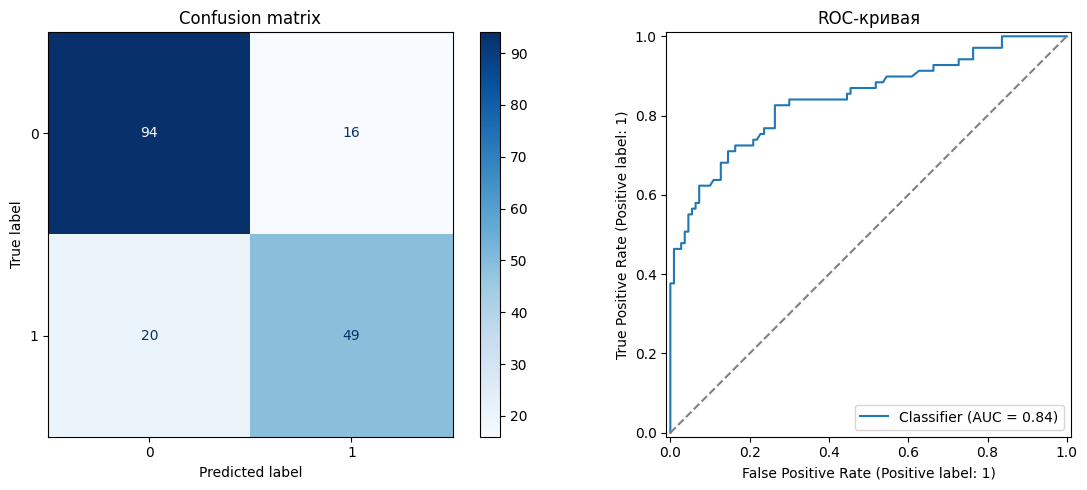

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax1, cmap="Blues")
ax1.set_title("Confusion matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax2.set_title("ROC-кривая")
plt.tight_layout()
plt.show()


## 5. RandomizedSearchCV

Делаем простой `RandomizedSearchCV` по `C`, `solver` и `class_weight` (метрика `F1`).


In [9]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_distributions = {
    "logreg__C": np.logspace(-3, 2, 30),
    "logreg__solver": ["liblinear", "lbfgs"],
    "logreg__class_weight": [None, "balanced"],
}

search = RandomizedSearchCV(
    baseline_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=67,
)
search.fit(X_train, y_train)

search.best_params_, search.best_score_


({'logreg__solver': 'lbfgs',
  'logreg__class_weight': 'balanced',
  'logreg__C': np.float64(13.738237958832638)},
 np.float64(0.7415302407987057))

## 6. Оцениваем лучшую модель


In [10]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [acc, accuracy_score(y_test, y_pred_best)],
    "Precision": [precision, precision_score(y_test, y_pred_best)],
    "Recall": [recall, recall_score(y_test, y_pred_best)],
    "F1": [f1, f1_score(y_test, y_pred_best)],
    "ROC-AUC": [roc_auc, roc_auc_score(y_test, y_proba_best)],
}

pd.DataFrame(metrics)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,Baseline,0.798883,0.753846,0.710145,0.731343,0.844071
1,Tuned,0.770950,0.694444,0.724638,0.709220,0.845125


### Как выглядит результат классификации?

Сведём предсказания в таблицу: вероятность класса 1, финальное решение и настоящий ответ.


In [11]:
pd.DataFrame({
    "prob_class1": y_proba_best.round(3),
    "predicted": y_pred_best,
    "true": y_test.reset_index(drop=True)
}).head(10)


,prob_class1,predicted,true
0,0.147,0,0
1,0.902,1,1
2,0.093,0,0
3,0.117,0,0
4,0.679,1,0
5,0.918,1,1
6,0.049,0,0
7,0.057,0,0
8,0.867,1,1
9,0.192,0,0


## 7. Выбор порога: обмениваем точность на полноту


In [ ]:
from sklearn.metrics import precision_score, recall_score

thresholds = [0.2, 0.5, 0.8]
rows = []
for thr in thresholds:
    y_thr = (y_proba_best >= thr).astype(int)
    rows.append({
        "threshold": thr,
        "precision": precision_score(y_test, y_thr),
        "recall": recall_score(y_test, y_thr),
        "f1": f1_score(y_test, y_thr),
    })

res_thr = pd.DataFrame(rows)
res_thr


,threshold,precision,recall,f1
0,0.2,0.516667,0.898551,0.656085
1,0.5,0.694444,0.724638,0.709220
2,0.8,0.897436,0.507246,0.648148


### 8. Итог по тюнингу (LR2 модель)

#### 1) Сначала фиксируем базовую метрику
Для классификации сравниваю модели по F1, потому что она учитывает и precision, и recall.

#### 2) Подбор гиперпараметров
Я сделал `RandomizedSearchCV` (n_iter=20, `cv=5`, `scoring='f1'`). Лучшие параметры можно посмотреть через `search.best_params_`.

У меня в итоге вышло примерно так:
- `solver='lbfgs'`
- `class_weight='balanced'`
- `C≈13.738`

#### 3) Сравнение на тесте (до и после)
Сравнил метрики Baseline и Tuned:
- Baseline: F1 ≈ 0.731343, ROC-AUC ≈ 0.844071
- Tuned: F1 ≈ 0.709220, ROC-AUC ≈ 0.845125

Что получилось по смыслу:
- `class_weight='balanced'` обычно помогает модели чаще находить класс 1, то есть recall может вырасти
- но из-за этого модель может начать чаще ошибаться и давать ложные срабатывания, из-за чего precision падает
- у меня так и вышло: recall чуть подрос, но precision упал, поэтому F1 стал хуже

#### 4) Вывод простыми словами
Я бы не оставлял эти настройки как финальные, потому что на тесте F1 стал хуже (0.731 → 0.709).

Если же цель другая (например, важнее поднять recall и “ловить” больше объектов класса 1), тогда `class_weight='balanced'` может быть норм вариантом, но это уже обмен точности на полноту.

#### 5) Про порог
С порогом всё стандартно:
- ниже порог → recall выше, precision ниже
- выше порог → precision выше, recall ниже

По моим значениям лучший баланс по F1 среди (0.2 / 0.5 / 0.8) получается примерно около 0.5.
